In [50]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', None)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report


from tensorflow.keras.preprocessing.text import Tokenizer


import joblib

#import gensim


from nltk.tokenize import word_tokenize
from hausastemmer import HausaStemmer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [51]:
df1 = pd.read_table('ha_train.tsv')
df2 = pd.read_table('ha_dev_gold_label.tsv')
df = pd.concat([df1, df2],ignore_index=True)
df.head()

,ID,tweet,label
0,ha_train_00001,@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣,negative
1,ha_train_00002,@user Kaga wani Adu ar Banda💔😭 wai a haka Shi ne shugaban sojoji.... Gaskiya Buhari kaci Amanan mu da kasa wannan mutum ah wajen nan,negative
2,ha_train_00003,@user Sai haquri fa yan madrid daman kunce champion din ya muku yawa😂,negative
3,ha_train_00004,@user Hmmm yanzu kai kasan girman allah daxakace mukuma ga Allah kune kukabarshi kuna karyata ayoyinsa kace allah baya karbar adduar talakan nigeria 🇳🇬 bayan kunzalunceshi kuma allah ya karbar adduar wanda aka zalunta cikin sauri amma kace wai Allah baya karbar addua talakawa,negative
4,ha_train_00005,@user @user Wai gwamno nin Nigeria suna afa kwayoyi ko 😂,negative


## EDA

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16849 entries, 0 to 16848
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      16849 non-null  object
 1   tweet   16849 non-null  object
 2   label   16849 non-null  object
dtypes: object(3)
memory usage: 395.0+ KB


The column

In [54]:
df['label'].value_counts()

label
neutral     5808
positive    5574
negative    5467
Name: count, dtype: int64

In [55]:
df['label'].isnull().sum()

0

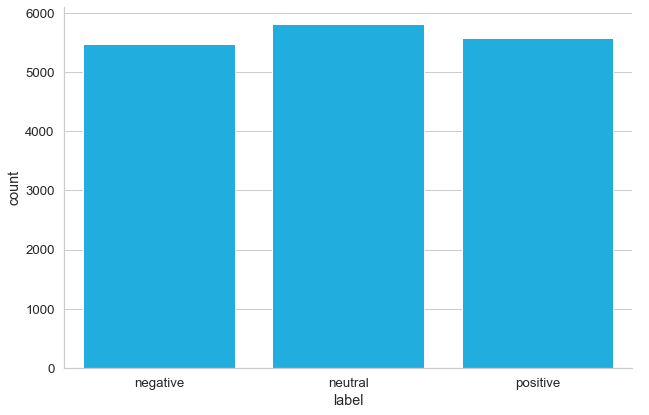

In [56]:
ax = sns.catplot(x="label", data=df, kind="count", height=6, aspect=1.5)
plt.show();

In [57]:
class_mapping = {'negative':0,'neutral':1,'positive':2}
df['label'] = df['label'].map(class_mapping)
class_names =['negative','neutal','positive']

    The tweets column


To analyze the text variable we create a class **TextCounts**. In this class we compute some basic statistics on the text variable. This class can be used later in a Pipeline, as well.

* **count_words** : number of words in the tweet

* **count_hashtags** : number of tag words, preceded by a #
* **count_capital_words** : number of uppercase words, could be used to *"shout"* and express (negative) emotions
* **count_excl_quest_marks** : number of question or exclamation marks
* **count_urls** : number of links in the tweet, preceded by http(s)
* **count_emojis** : number of emoji, which might be a good indication of the sentiment

In [58]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                        
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [10]:
tc = TextCounts()
df_eda = tc.fit_transform(df.tweet)

df_eda['label'] = df['label']

Descriptive stats for count_words
---------------------------------
        count       mean        std  min  25%   50%   75%   max
label                                                          
0      5467.0  16.351747  11.482647  4.0  8.0  13.0  21.0  60.0
1      5808.0  11.175103   7.600890  4.0  6.0   9.0  13.0  56.0
2      5574.0  14.177610   9.904099  3.0  7.0  11.0  18.0  61.0


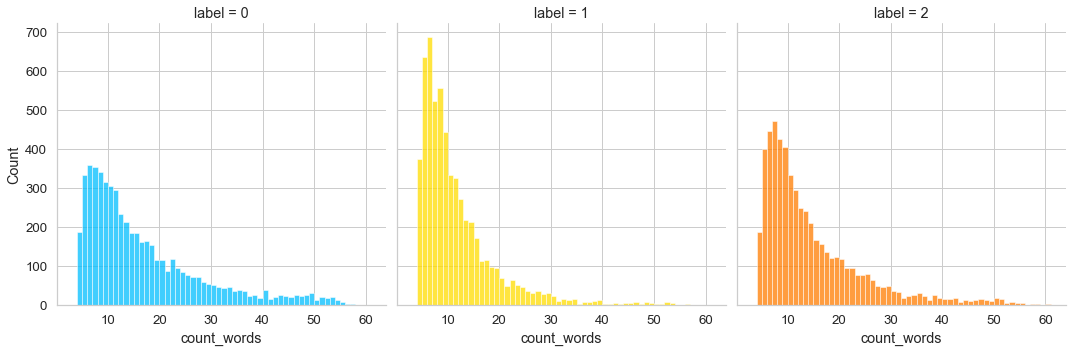

In [11]:
def show_hist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='label', height=5, hue='label')
    g = g.map(sns.histplot, col, kde=False, bins=bins)
    plt.show()
   
show_hist(df_eda, 'count_words')

Descriptive stats for count_hashtags
------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5467.0  0.026340  0.215655  0.0  0.0  0.0  0.0   6.0
1      5808.0  0.032886  0.332686  0.0  0.0  0.0  0.0  14.0
2      5574.0  0.034266  0.232962  0.0  0.0  0.0  0.0   4.0


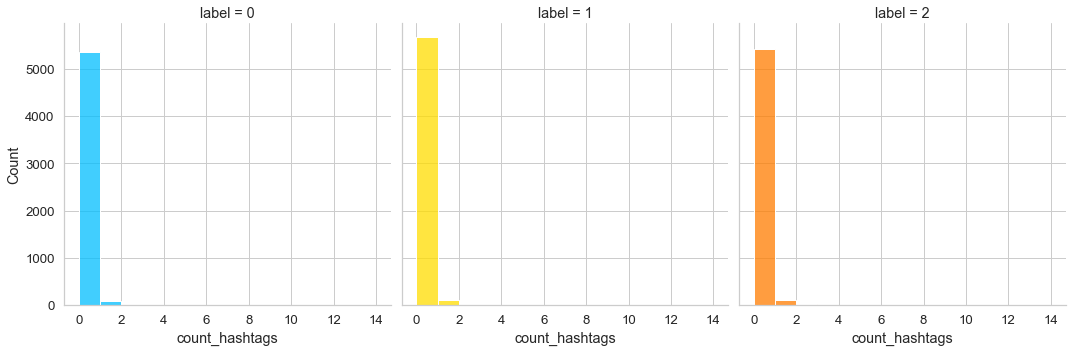

In [12]:
show_hist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5467.0  0.168831  1.122987  0.0  0.0  0.0  0.0  31.0
1      5808.0  0.146006  1.027786  0.0  0.0  0.0  0.0  41.0
2      5574.0  0.188913  1.316439  0.0  0.0  0.0  0.0  51.0


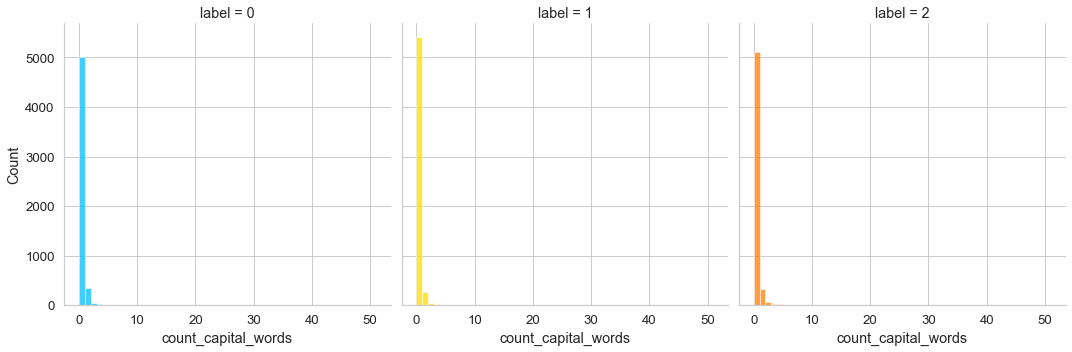

In [13]:
show_hist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5467.0  0.213097  0.707591  0.0  0.0  0.0  0.0  11.0
1      5808.0  0.192665  0.610652  0.0  0.0  0.0  0.0  12.0
2      5574.0  0.108001  0.549535  0.0  0.0  0.0  0.0  19.0


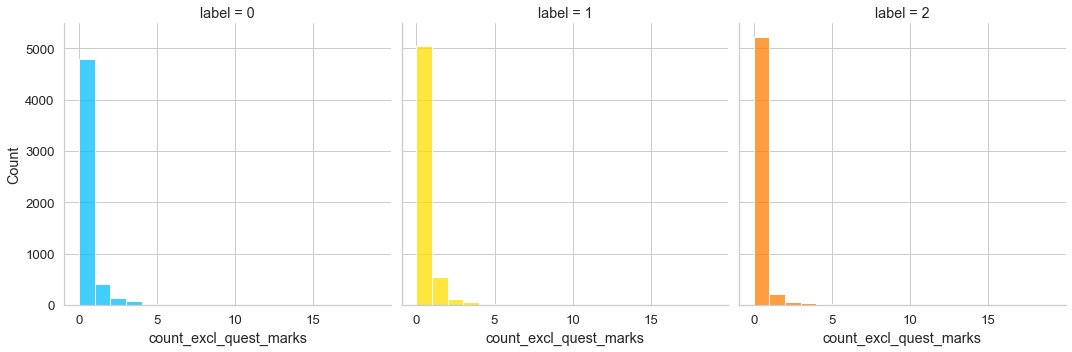

In [14]:
show_hist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0      5467.0  0.027986  0.173594  0.0  0.0  0.0  0.0  2.0
1      5808.0  0.040461  0.213014  0.0  0.0  0.0  0.0  3.0
2      5574.0  0.027987  0.170303  0.0  0.0  0.0  0.0  2.0


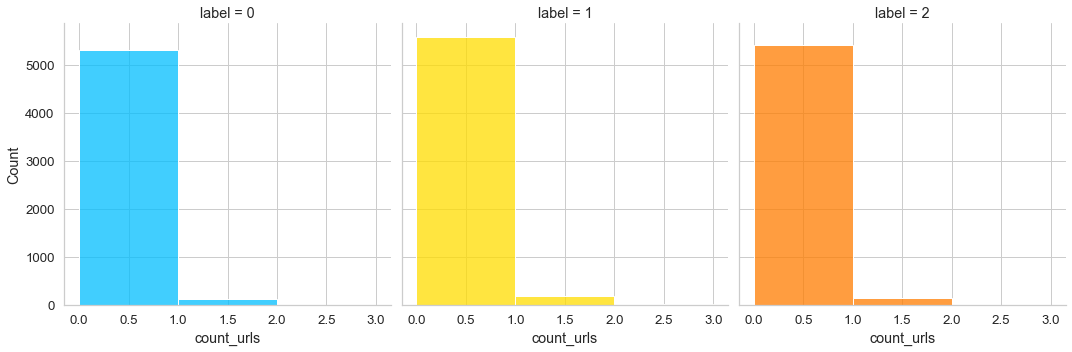

In [15]:
show_hist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
        count      mean       std  min  25%  50%  75%    max
label                                                       
0      5467.0  2.198646  2.875457  0.0  1.0  2.0  3.0  126.0
1      5808.0  1.966942  1.691746  0.0  1.0  1.0  3.0   32.0
2      5574.0  1.994080  2.235177  0.0  1.0  1.0  3.0   88.0


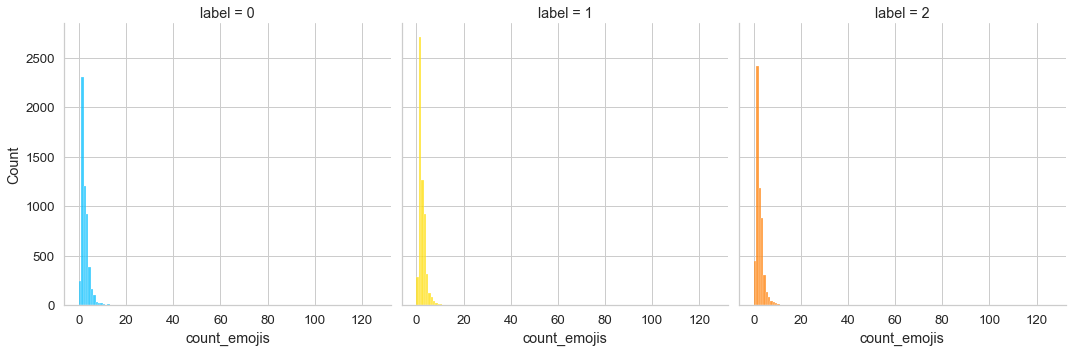

In [16]:
show_hist(df_eda, 'count_emojis')

### Code-mixed handling
This is handle in other notebook separatly

In [147]:
detectlanguage.detect("user Da kudin da Arewa babu wani abin azo aga")

[{'language': 'ha', 'isReliable': True, 'confidence': 10.68}]

## Removing the Stemming for Ablation study

In [59]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def remove_stopwords(self, input_text):
            
        # This stop are a gotting from the different online repositories as there is no standardation on the Huasa stopword.
        stopwords_list = ['a', 'amma', 'ba', 'ban', 'ce', 'cikin', 'da', 'don', 'ga', 'in', 'ina', 'ita', 'ji', 'ka', 'ko', 'kuma', 'lokacin', 'ma', 'mai', 'na', 'ne', 'ni', 'sai', 'shi', 'su', 'suka', 'sun', 'ta', 'tafi', 'take', 'tana', 'wani', 'wannan', 'wata', 'ya', 'yake', 'yana', 'yi', 'za']
        
        # This stop are a gotting from the different online repositories as there is no standardation on the Huasa stopword.
        words = input_text.split()
        clean_words = [w for w in words if not w in  stopwords_list]
        return " ".join(clean_words) 
    
    # filterout the words that are single
    def single_word_fillter(self, input_text):
        
        words = input_text.split()
        filtered_words = [word for word in words if len(word)> 1]
        return " ".join(filtered_words) 
    
    #def stemming(self, input_text):
    #    hausastemmer = HausaStemmer()
    #   words = input_text.split() 
    #   stemmed_words = [ hausastemmer.stem(word) for word in words]
    #   return " ".join(stemmed_words)
    
    def to_lower(self, input_text):
        return input_text.lower()

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.single_word_fillter) #.apply(self.stemming)
        return clean_X
    


In [60]:
ct = CleanText()
sr_clean = ct.fit_transform(df.tweet)
sr_clean.sample(1)

3015    dan bura uban yaji atah 😂😂😂
Name: tweet, dtype: object

### checking an empty tweet

In [61]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


In [62]:
#To show how the cleaned text variable will look like, here's a sample.
ct = CleanText()
cleaned_tweets = ct.fit_transform(df.tweet)
df['cleaned_tweet'] = cleaned_tweets  # Add the cleaned tweets as a new column
df.sample(1)
df.to_csv('clean_hausa_tweet.csv', index= False)

Now that we have the cleaned text of the tweets, we can have a look at what are the most frequent words. Below we'll show the top 20 words. 

**CONCLUSION: **Not surprisingly the most frequent word is Allah.

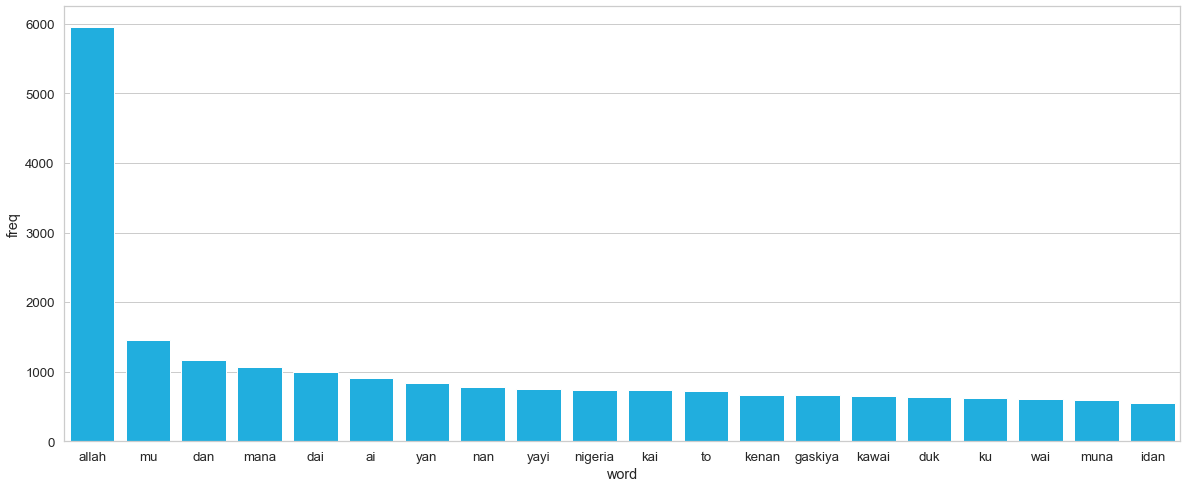

In [63]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names_out(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(20, 8))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df)
plt.show();

In [26]:
pip install keras-utils

  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=f29f916c09aa67e1afd8a369dc7949bea79654e94b1cd151fa672a21f5f6e6f7
  Stored in directory: /Users/aliyuyusuf/Library/Caches/pip/wheels/fd/b9/6e/25d4c3a3c0319873aeeab6592c5b4bb9e2af0fec21a0b5188c
Successfully built keras-utils
Note: you may need to restart the kernel to use updated packages.


## <a id="5">Splitting the Data</a>

In [64]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


#from tensorflow.keras.utils.to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers



In [65]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 32  # Size of the batches used in the mini-batch gradient descent

GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
MAX_LEN = 120  # Maximum number of words in a sequence
LEARNING_RATE = 1e-5
DROPOUT_RATE=0.3

In [66]:
df.head()

,ID,tweet,label,cleaned_tweet
0,ha_train_00001,@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣,0,kudin arewa babu abin azo agani yayi wa alummah allah isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace cinhanci rashawa fili nigeria jamiyaryar tabataman mlm 😭🗣
1,ha_train_00002,@user Kaga wani Adu ar Banda💔😭 wai a haka Shi ne shugaban sojoji.... Gaskiya Buhari kaci Amanan mu da kasa wannan mutum ah wajen nan,0,kaga adu ar banda💔😭 wai haka shugaban sojoji gaskiya buhari kaci amanan mu kasa mutum ah wajen nan
2,ha_train_00003,@user Sai haquri fa yan madrid daman kunce champion din ya muku yawa😂,0,haquri fa yan madrid daman kunce champion din muku yawa😂
3,ha_train_00004,@user Hmmm yanzu kai kasan girman allah daxakace mukuma ga Allah kune kukabarshi kuna karyata ayoyinsa kace allah baya karbar adduar talakan nigeria 🇳🇬 bayan kunzalunceshi kuma allah ya karbar adduar wanda aka zalunta cikin sauri amma kace wai Allah baya karbar addua talakawa,0,hmmm yanzu kai kasan girman allah daxakace mukuma allah kune kukabarshi kuna karyata ayoyinsa kace allah baya karbar adduar talakan nigeria 🇳🇬 bayan kunzalunceshi allah karbar adduar wanda aka zalunta sauri kace wai allah baya karbar addua talakawa
4,ha_train_00005,@user @user Wai gwamno nin Nigeria suna afa kwayoyi ko 😂,0,wai gwamno nin nigeria suna afa kwayoyi


In [67]:
df.columns

Index(['ID', 'tweet', 'label', 'cleaned_tweet'], dtype='object')

In [68]:
print(df['cleaned_tweet'].apply(type).value_counts())

cleaned_tweet
<class 'str'>    16849
Name: count, dtype: int64


In [69]:
df = df[df['cleaned_tweet'].apply(lambda x: isinstance(x, str))]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_tweet, df.label, test_size=0.2, random_state=101)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13479
# Test data samples: 3370


In [71]:
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]

# Tokenize the text data
tk = Tokenizer(num_words=NB_WORDS, split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [72]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [73]:
X_train_seq_trunc[20]  # Example of padded sequence

array([   1,   44,   40,  131,  291,    1,   44,  263,   54,   99,    1,
         24,    2,  459, 1890, 8757, 8758, 1171,  768, 1304,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [74]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [75]:
y_train_le

array([0, 1, 0, ..., 1, 1, 2])

The model overfits fast. Moreover the test accuracy is lower compared to the embeddings trained on the training data. 

As a final exercise, let's see what results we get when we train the embeddings with the same number of dimensions as the GloVe data.

## Training without word embeddings

In [76]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

### TRAINING CNN MODEL

Epoch 1/20


/Users/aliyuyusuf/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


380/380 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.3650 - loss: 30.7478 - val_accuracy: 0.3909 - val_loss: 9.0889
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3751 - loss: 17.5319 - val_accuracy: 0.3702 - val_loss: 6.3678
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3611 - loss: 12.7419 - val_accuracy: 0.3954 - val_loss: 5.1526
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3615 - loss: 9.4687 - val_accuracy: 0.3880 - val_loss: 4.2706
Epoch 5/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3656 - loss: 7.1529 - val_accuracy: 0.4169 - val_loss: 3.4635
Epoch 6/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3756 - loss: 5.1096 - val_accuracy: 0.4043 - val_loss: 2.9329
Epoch 7/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3724 - loss: 3.9737 - val_accuracy: 0.4028 - val_loss: 2.3760
Epoch 8/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3776 - loss: 2.8998 - val_accuracy: 0.

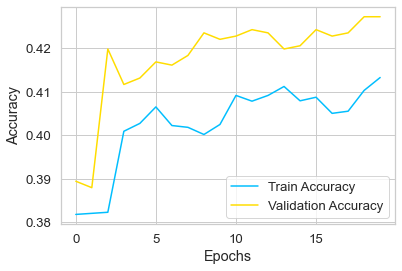

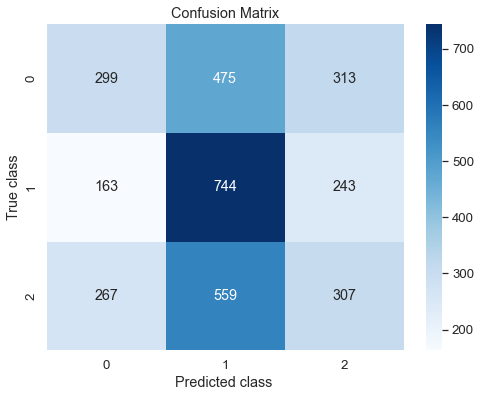

In [77]:
# Load and preprocess your data (replace 'df.tweet' and 'df.label' with your data)
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_tweet, df.label, test_size=0.2, random_state=101)
tokenizer = Tokenizer(num_words=NB_WORDS, split=" ")
tokenizer.fit_on_texts(X_train)




from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_LEN)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the input data to have three dimensions
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

# ...

# Define the CNN model without embedding layer
cnn_model = Sequential()
cnn_model.add(Conv1D(128, 3, activation='relu', input_shape=(MAX_LEN, 1)))
cnn_model.add(MaxPooling1D(2))
cnn_model.add(Conv1D(128, 3, activation='relu'))
cnn_model.add(MaxPooling1D(2))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(DROPOUT_RATE))
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

history = cnn_model.fit(X_train_seq, y_train, 
                        epochs=NB_START_EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_split=0.1, 
                        #callbacks=[early_stopping], 
                        verbose=1)

# Train the model
history = cnn_model.fit(X_train_seq, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE,
                        validation_split=0.1, verbose=1)

# Evaluate the model on test data
loss, accuracy = cnn_model.evaluate(X_test_seq, y_test, verbose=0)

print("===================================================================================================\n")
# Get predictions on the test data
y_pred = cnn_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate and print the classification report
print("===================================================================================================\n")
report_CNN = classification_report(np.argmax(y_test, axis=1), y_pred_classes)
print("Classification Report for CNN Model:\n", report_CNN)

print("===================================================================================================\n")
print('Test loss and accuracy value ')
# Print test loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print("===================================================================================================\n")

print('Train and validation curve')
# Plot training history (optional)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("===================================================================================================\n")
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class ')
plt.ylabel('True class')
plt.title('Confusion Matrix')
plt.show()